In [71]:
# Import knihoven
from mpopt import mp
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

In [72]:
# Definice OCP
ocp = mp.OCP(n_states=12, n_controls=4)

In [73]:
def dynamics1(x, u, t):
    # Parametry
    C_T = 1.28192e-8      # koeficient tahu rotoru
    C_M = 5.964552e-3     # koeficient momentu rotoru
    rad_max = (2 * np.pi * 64 * 200) / 60  # maximální otáčky [rad/s]
    rad_min = (2 * np.pi * 64 * 18) / 60     # minimální otáčky [rad/s]
    rpm_max = rad_max * 9.5492968            # maximální otáčky [rpm]
    rpm_min = rad_min * 9.5492968            # minimální otáčky [rpm]
    arm_length = 0.0397     # délka ramene [m]

    g = 9.81       # tíhové zrychlení [m/s²]
    m = 0.03       # hmotnost dronu [kg]
    Ix = 1.657e-5  # moment setrvačnosti kolem osy x [kg·m²]
    Iy = 1.666e-5  # moment setrvačnosti kolem osy y [kg·m²]
    Iz = 2.926e-5  # moment setrvačnosti kolem osy z [kg·m²]

    Ts = 1e-3    # perioda vzorkování [s]

    # Limity tahu (každý rotor)
    f_max = 0.15   # maximální tah jednoho rotoru [N]
    f_min = 0.0

    # Definice stavů a vstupu
    # Stav: x = [x, y, z, vx, vy, vz, phi, theta, psi, p, q, r]
    # Celkový tah a momenty
    F = u[0] + u[1] + u[2] + u[3]
    tau_phi   = arm_length * (u[3] - u[1])
    tau_theta = arm_length * (u[2] - u[0])
    tau_psi   = (C_M / C_T) * (u[0] - u[1] + u[2] - u[3])

    # Rozbalení stavů
    pos = x[0:3]      # poloha: [x, y, z]
    vel = x[3:6]      # rychlost: [vx, vy, vz]
    phi   = x[6]      # natočení
    theta = x[7]
    psi   = x[8]
    p     = x[9]      # úholvá rychlost
    q     = x[10]
    r     = x[11]

    # Rotace dle Eulerových úhlů
    fx = (F/m) * (ca.cos(phi)*ca.sin(theta)*ca.cos(psi) + ca.sin(phi)*ca.sin(psi))
    fy = (F/m) * (ca.cos(phi)*ca.sin(theta)*ca.sin(psi) - ca.sin(phi)*ca.cos(psi))
    fz = (F/m) * (ca.cos(phi)*ca.cos(theta)) - g

    # Kinematika Eulerových úhlů
    phi_dot   = p + q * ca.sin(phi) * ca.tan(theta) + r * ca.cos(phi) * ca.tan(theta)
    theta_dot = q * ca.cos(phi) - r * ca.sin(phi)
    psi_dot   = q * ca.sin(phi) / ca.cos(theta) + r * ca.cos(phi) / ca.cos(theta)

    # Dynamika otáčení
    p_dot = (tau_phi - (Iy - Iz) * q * r) / Ix
    q_dot = (tau_theta - (Iz - Ix) * p * r) / Iy
    r_dot = (tau_psi - (Ix - Iy) * p * q) / Iz

    # Diferenciální rovnice
    # x_dot = ca.vertcat(vel[0],
    #                 vel[1],
    #                 vel[2],
    #                 fx,
    #                 fy,
    #                 fz,
    #                 phi_dot,
    #                 theta_dot,
    #                 psi_dot,
    #                 p_dot,
    #                 q_dot,
    #                 r_dot)
    x_dot = [vel[0],
                vel[1],
                vel[2],
                fx,
                fy,
                fz,
                phi_dot,
                theta_dot,
                psi_dot,
                p_dot,
                q_dot,
                r_dot]
    return x_dot

In [74]:
# Nastavení dynamiky pro OCP 
def get_dynamics1():
    dynamics0 = lambda x, u, t: dynamics1(x, u, t)

    return [dynamics0]
ocp.dynamics = get_dynamics1()

In [ ]:
# Váhové matice Q a R 
Q = np.diag([100, 100, 100, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
# Q = np.diag([100, 100, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0])
R = np.diag([1, 1, 1, 1])

# Trajektorie
# Koeficienty polynomu
ax = [0.1, -0.2, 0.3, 0]  # Koeficienty pro x(t)
by = [0, 0.2, -0.1, 0.4]  # Koeficienty pro y(t)
cz = [-0.1, 0.1, 0, 0.2]  # Koeficienty pro z(t)

# Reference na testování
# x_ref = np.array([5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0])    # Let do bodu
u0 = np.array([0.073575, 0.073575, 0.073575, 0.073575])

# Nastavení hodnotící funkce J
def running_cost1(x, u, t):
    # # Vypočet trajektorie
    # xt = np.polyval(ax, t[0])
    # yt = np.polyval(by, t[0])
    # zt = np.polyval(cz, t[0])
    # # Trajektorie polynomu závislém na čase
    # x_ref = np.array([xt,yt,zt,0,0,0,0,0,0,0,0,0])
    
    # Trajektorie spirály
    x_ref = np.array([ca.cos(t)-1,ca.sin(t),t[0],0,0,0,0,0,0,0,0,0])

    x_err = x - x_ref
    u_err = u - u0
    
    return (x_err.T @ Q @ x_err) + (u_err.T @ R @ u_err)

    # # Verze s terminal_cost
    # return (x.T @ Q @ x) + (u.T @ R @ u)
ocp.running_costs[0] = running_cost1


In [ ]:
# # Omezení na cestu
# # V kombinaci letem do bodu
# def path_constrains0(x, u, t):
#     x0 = 3
#     y0 = 3
#     z0 = 3
#     return [
#         25.0 - (x[0]-x0)*(x[0]-x0) - (x[1]-y0)*(x[1]-y0) - (x[2]-z0)*(x[2]-z0)
#     ]

# ocp.path_constraints[0] = path_constrains0

In [77]:
# def terminal_cost1(xf, tf, x0, t0):
#     return -4

# ocp.terminal_costs[0] = terminal_cost1
# random_array = np.array([1,1,1,0,0,0,0,0,0,0,0,0])
# random_array2 = np.array([np.sin(2),np.sin(2),np.sin(2),0,0,0,0,0,0,0,0,0])
# print(random_array*np.sin(2))
# print(random_array2)

In [87]:
u_stable = 0.073575
u_max = 0.15

# Počáteční stav
# ocp.x00[0] = np.zeros(12)
ocp.x00[0] = np.array([0,0,0,0,0,0,0,0,0,0,0,0])
# Omezení vstupů
ocp.lbu[0] = np.array([0,0,0,0])
# ocp.ubu[0] = rpm_max
ocp.ubu[0] = np.array([0.15,0.15,0.15,0.15])
ocp.lbtf[0] = 5
ocp.ubtf[0] = 10

In [88]:
# Validace modelu
ocp.validate()


 *********** MPOPT Summary ********** 

 Optimal cost (J):  51.6196 

 Solved in 2858.079 ms
 	 OCP transcription time  : 284.357 ms
 	 NLP solution time       : 2573.722 ms

 Post processed in 86.531 ms
 	 Solution retrieval            : 0.254 ms
 	 Residual in dynamics           : 23.309 ms
 	 Process solution and plot      : 62.967 ms
hotovo!


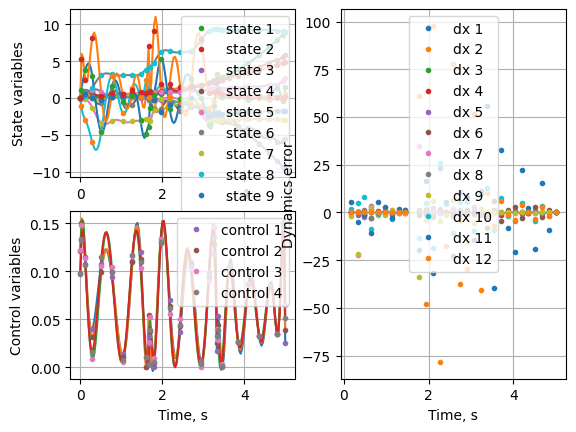

In [89]:
# Řešení
mpo, post = mp.solve(ocp, n_segments=3, poly_orders=10, scheme="LGR", plot=True)
print('hotovo!')

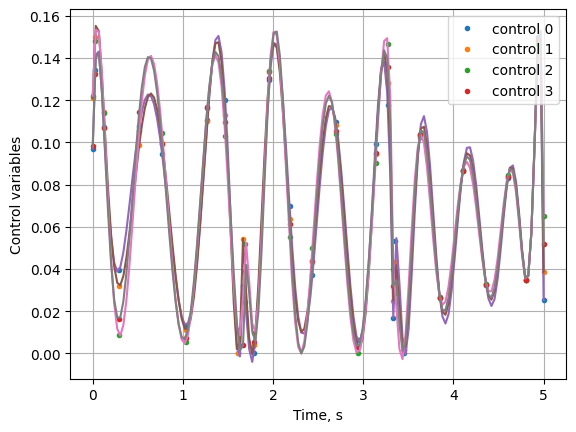

In [90]:
# # Testovaci okenko
inputs = post.plot_u()

[ 8.97508184  4.95673653 -9.72031248  5.85920616  2.69177317 -5.52546038
 -2.92344252  9.03722061 -1.70490015  0.51798644  1.50895636  0.09735314]


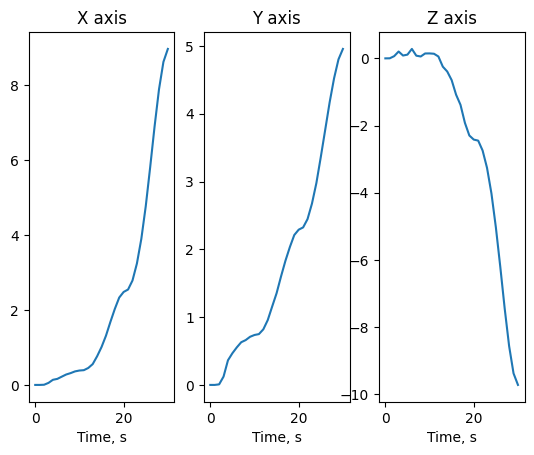

In [91]:
data = post.get_data()
data = data[0]
position = np.zeros([3, np.size(data,0)])

for i in range(np.size(data,0)):
    position[0][i] = data[i][0]
    position[1][i] = data[i][1]
    position[2][i] = data[i][2]

# print(position)

plt.subplot(1,3,1)
plt.plot(position[0])
plt.title("X axis")
plt.xlabel("Time, s")
plt.subplot(1,3,2)
plt.plot(position[1])
plt.title("Y axis")
plt.xlabel("Time, s")
plt.subplot(1,3,3)
plt.plot(position[2])
plt.title("Z axis")
plt.xlabel("Time, s")

print(data[-1])

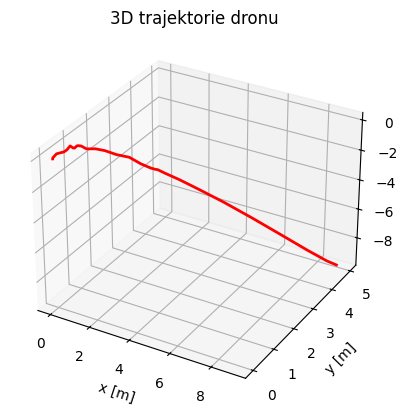

In [92]:
# 3D trajektorie (poloha v prostoru)
data = post.get_data()
data = data[0]
position = np.zeros([3, np.size(data,0)])

for i in range(np.size(data,0)):
    position[0][i] = data[i][0]
    position[1][i] = data[i][1]
    position[2][i] = data[i][2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(position[0], position[1], position[2], 'r', linewidth=2)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('3D trajektorie dronu')
plt.show()

# plt.plot(position[0],position[1])